--
title: Multi-level modeling with binomial GLM with baseball on-base percentage
mathjax: True
--

A few months ago, I professed my interest in learning multi-level models. It took me through a journey where I dove into Bayesian inference. I recently learned multi-level models (also known as heirarchical models) and the concepts of shrinkage and partial pooling were really interesting to me. Multi-level models can make more accurate estimates, especially when groups have unequal sample sizes.

Let's illustrate this with baseball data. Specifically, we want to estimate on-base percentage (OBP) of opposing batters that the Padres faced in the month of August 2021. Getting "on base" is a binary event and therefore we will use a binomial generalized linear model. I'm specifically interested in the starting batta OBP under the two pitching coaches the Padres had that month. I'm purposefully picking this time frame because the Padres made a change to their pitching coach on August 23. We can see the effect of different sample sizes using the pitching coaches as grouping variables. I'm hiding the data pulling process for simplicity, but I used the pybaseball package. I'll focus on the modeling component using pymc3. Much of this approach and code is inspired by Chapter 13 in [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). 

We'll look at the results when analyzed with fixed and multi-level (AKA mixed effects) models.

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from scipy.special import expit as logistic
from scipy.special import logit
import daft
from causalgraphicalmodels import CausalGraphicalModel


<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
sns.set_context("talk")

<IPython.core.display.Javascript object>

In [ ]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Causal model

Before we dive into the statistics, it helps to consider a causal model. Obviously, the pitching coach is not facing the opposing batters, but instead their counsel is passed to the Padres pitchers. The symbols below are:
- C = Padres pitching coach
- P = starting Padres pitcher
- OB = on-base event

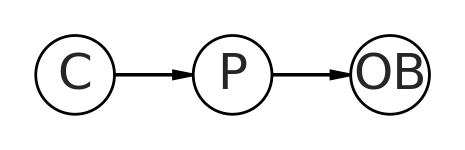

<IPython.core.display.Javascript object>

In [8]:
## DAG
pipe_dag = CausalGraphicalModel(
    nodes=["C", "P", "OB"],
    edges=[
        ("C", "P"),
        ("P", "OB"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "C": (0, 0),
    "P": (1, 0),
    "OB": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

This is an oversimplified example but it helps to consider what variables to include or exclude. In this diagram, P is acting as a mediator between C and OB. This means that information from C is piped through P to influence OB. If we imagine that C is a treatment variable (we have two pitching coaches in August), we can view P as a post-treatment variable. To understand the influence of C, we would not want to block this path of information, so we should *exclude* P from a model. (However, to determine how much influence C has, we can add P in to see how the coefficient for C changes. We'll return to this point later.)

# Exploring and preparing the data

In [33]:
DATA_DIR = "other_data/"
df_padres = pd.read_csv(
    DATA_DIR + "df_padres_pitching_summary_August2021.csv", index_col=0
).drop("index", axis=1)

# data cleaning (Arrietta did not start for the Padres until 8/18)
df_padres = df_padres.loc[~((df_padres['pitcher'] == "('arrieta', 'jake')")  & (df_padres['game_date'] < '2021-08-18')), :].copy()

print("Shape of df: ", df_padres.shape)

# Take a look at the df
df_padres

Shape of df:  (26, 6)


,pitcher,game_date,n_ab,n_ob,obp,pitching_coach
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild
5,"('darvish', 'yu')",2021-08-07,25,4,0.160000,Rothschild
6,"('snell', 'blake')",2021-08-08,26,5,0.192308,Rothschild
7,"('musgrove', 'joe')",2021-08-09,24,6,0.250000,Rothschild
8,"('stammen', 'craig')",2021-08-10,11,6,0.545455,Rothschild
9,"('weathers', 'ryan')",2021-08-11,21,8,0.380952,Rothschild
10,"('darvish', 'yu')",2021-08-12,15,7,0.466667,Rothschild


<IPython.core.display.Javascript object>

In [42]:
# Look at the sample size differences for each coach
(
    df_padres
    .groupby("pitching_coach")
    .sum("n_ab")
    .sort_values(by='n_ab')
).loc[:, 'n_ab']


pitching_coach
Fritz         139
Rothschild    344
Name: n_ab, dtype: int64

<IPython.core.display.Javascript object>

The dataframe has 26 dates, representing the game days for the month of August. The Padres used 10 starting pitchers, which is typically higher than most teams, reflecting the team's dire injury situation, but the focus here is on the coaches. You can see that Rothschild was the pitching coach for the majority of the month, reflecting the difference in sample sizes which will help us see the effect of the mixed model.

# Preparing the dataframe

Now for the modeling. I purposefully simplified this scenario so that we can use a binomial GLM. We'll build one fixed effect model with normal, regularizing priors that does not use grouping. We'll then build a multi-level model under the pitching_coach variable.

First we'll have to encode our categorical variables for `pitching_coach`. We won't use `pitcher` right away but we can encode that as well. We'll ignore game_date.

In [44]:
# Pitcher code assignment
df_padres["pitcher_code"] = pd.Categorical(df_padres["pitcher"]).codes
df_pitcher_code = (
    df_padres[["pitcher", "pitcher_code"]]
    .drop_duplicates()
    .sort_values(by="pitcher_code")
    .reset_index(drop=True)
    .copy()
)

# Pitching_coach code assignment
df_padres["coach_code"] = pd.Categorical(
    df_padres["pitching_coach"], categories=["Rothschild", "Fritz"]
).codes

df_coach_code = (
    df_padres[["pitching_coach", "coach_code"]]
    .drop_duplicates()
    .sort_values(by="coach_code")
    .reset_index(drop=True)
    .copy()
)
# Look at pitching_coach code assignment
df_coach_code

,pitching_coach,coach_code
0,Rothschild,0
1,Fritz,1


<IPython.core.display.Javascript object>

Here's what the dataframe looks like now (first five and last five rows).

In [45]:
pd.concat([df_padres.head(), df_padres.tail()], axis=0)

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,coach_code,pitcher_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,0,3
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,0,6
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,0,4
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,0,9
5,"('darvish', 'yu')",2021-08-07,25,4,0.160000,Rothschild,0,1
22,"('darvish', 'yu')",2021-08-26,24,6,0.250000,Fritz,1,1
23,"('musgrove', 'joe')",2021-08-27,32,5,0.156250,Fritz,1,4
24,"('weathers', 'ryan')",2021-08-28,12,4,0.333333,Fritz,1,9
25,"('paddack', 'chris')",2021-08-30,17,3,0.176471,Fritz,1,5
26,"('snell', 'blake')",2021-08-31,23,2,0.086957,Fritz,1,6


<IPython.core.display.Javascript object>

We can also create variables for the number of different pitchers and coaches for use in our model.

In [46]:
n_pitcher = len(df_padres["pitcher"].unique())
n_coach = len(df_padres["pitching_coach"].unique())

print("No. of different pitchers: ", n_pitcher)
print("No. of different coaches: ", n_coach)

No. of different pitchers:  10
No. of different coaches:  2


<IPython.core.display.Javascript object>

# `Coach` only model
Let's look at a fixed effects with an intercept-only model of just coach.

## Fixed effects

**Model `m1` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach, encoded as index variables}$$

$$\alpha_j \sim \text{Normal}(0, 2) \tag{regularizing prior for each coach}$$

In [47]:
# modified from repo
with pm.Model() as m1:
    # regularizing priors
    a = pm.Normal("a", 0.0, 2, shape=n_coach)
    # linear model
    p = pm.math.invlogit(a[df_padres["coach_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [48]:
df_summary1 = az.summary(trace_m1)
df_summary1

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.649,0.112,-0.814,-0.455,0.002,0.001,3016.0,3016.0,3007.0,2376.0,1.0
a[1],-1.514,0.217,-1.864,-1.178,0.004,0.003,3398.0,3362.0,3398.0,2924.0,1.0


<IPython.core.display.Javascript object>

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

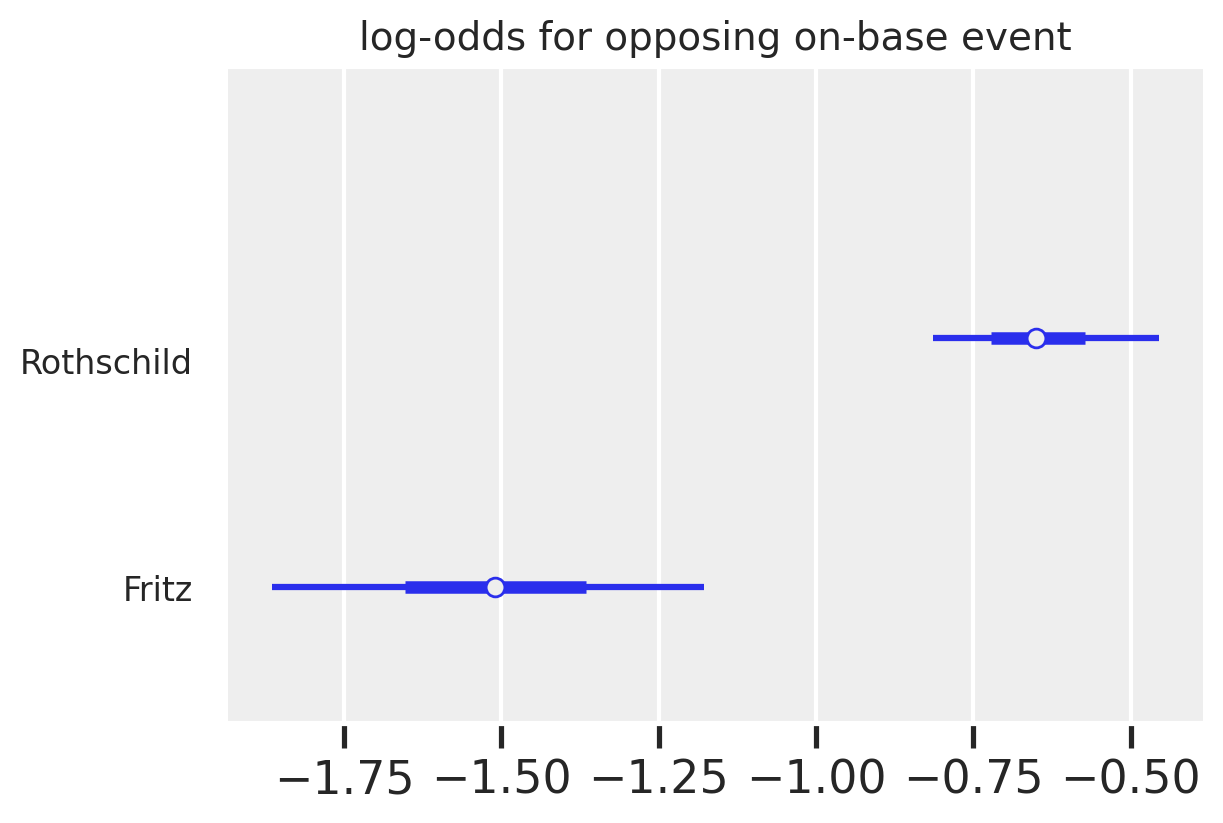

<IPython.core.display.Javascript object>

In [53]:
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
ax1.set_title("log-odds for opposing on-base event", size=14)
ax1.set_yticks([0, 0.75])
ax1.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

It clearly looks like performance under Fritz outperformed Rothschild in this month. But before we make any strong statements, we should consider the sample size, since Fritz's tenure as pitching coach during the month was much shorter than Rothschild's. This is where a mixed effects model can help deal with groups where sample sizes are unequal.

## Mixed effects

### Centered paramaterization
A centered parameterization is easier to understand and so let's start with this. Here, we use an adaptive prior where we don't hardcode our paramaters. This structure instead *learns* from the data itself to determine the appropriate amount of regularization. This is how information across groups (pitching coaches in this case) can be shared. Concretely, we use the performance under Rothschild to get a more accurate estimate under Fritz and vice versa.

**Model `m2` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1) \tag{prior for average coach}$$

$$ \sigma \sim \text{Half-Normal}(0, 1) \tag{prior for standard deviation of coaches} $$

In [54]:
with pm.Model() as m2:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1)

    # prior for standard deviation of coachs
    sigma = pm.HalfNormal("sigma", sigma=1)

    # addaptive prior learns across coachs
    a = pm.Normal("a", a_bar, sigma, shape=n_coach)

    # linear model
    p = pm.math.invlogit(a[df_padres["coach_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune, target_accept
    trace_m2 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

"Divergences" were noted but we'll address this in another post.

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

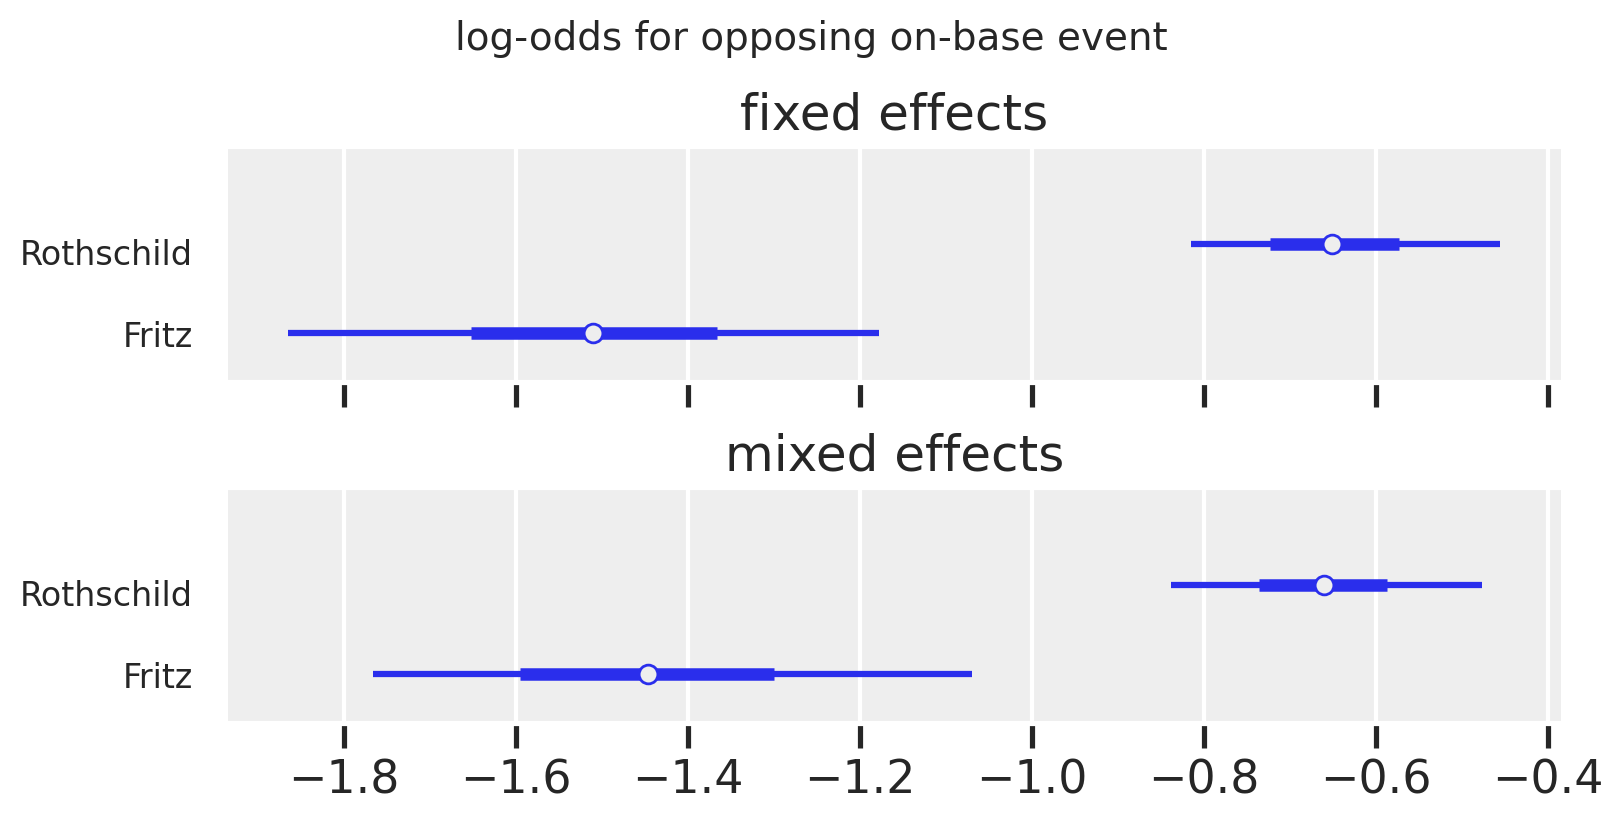

<IPython.core.display.Javascript object>

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
f.suptitle("log-odds for opposing on-base event", size=14)
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
ax1.set_title("fixed effects")
ax1.set_yticks([0, 0.75])
ax1.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

az.plot_forest(trace_m2, var_names="a", combined=True, ax=ax2)
ax2.set_title("mixed effects")
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

It's interesting that there is a *little* bit of movement of each coach's posterior distribution towards each other, but it is not that significant. It essentially means that while sample size differences were present (Rothschild tenure was 344 at-bats while Fritz's was 139), the absolute number was large enough to make an estimate for that month.


Now let's ask a different question. What is the effect of the coach after controlling for pitcher? This is where we go back to our DAG at the top. If we include pitcher in the model, how will that affect our estimate for coach? Before we address the question with code, we can think about this. If the influence of coach is reliably large, then including `pitcher` in the model equation would shrink the `coach` estimate towards zero, since we would not gain additional information by including `pitcher`. Now let's find out, going straight to using a mixed effects model.

# `Pitcher` and `Coach` models

## Mixed effects

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{pitcher and coach, encoded as index variables}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) \tag{adaptive prior for pitcher}$$

$$\gamma_j \sim \text{Normal}(0, \sigma_{\gamma}) \tag{adaptive prior for coach}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

$$\sigma_{\gamma} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

In [183]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code,coach_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,3,0,0
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,6,0,0
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,4,0,0
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild,0,0,0
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,9,0,0


<IPython.core.display.Javascript object>

In [43]:
# modified from repo
with pm.Model() as m1:
    # regularizing priors
    a = pm.Normal("a", 0.0, 2, shape=n_pitcher)
    g = pm.Normal("g", 0.0, 2, shape=n_coach)
    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]] + g[df_padres["coach_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a]
INFO:pymc3:NUTS: [g, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [44]:
df_summary1 = az.summary(trace_m1)
df_summary1

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.339,0.691,-0.832,1.408,0.026,0.019,689.0,689.0,693.0,1415.0,1.01
a[1],-0.419,0.671,-1.541,0.600,0.025,0.018,712.0,712.0,713.0,1154.0,1.01
a[2],0.543,0.988,-1.006,2.163,0.025,0.018,1505.0,1505.0,1508.0,2225.0,1.00
a[3],-1.024,0.919,-2.441,0.424,0.026,0.019,1229.0,1229.0,1233.0,1556.0,1.01
a[4],-0.434,0.642,-1.559,0.497,0.026,0.018,612.0,612.0,611.0,993.0,1.01
a[5],-0.471,0.851,-1.865,0.833,0.027,0.019,1023.0,1023.0,1019.0,1897.0,1.00
a[6],-0.670,0.637,-1.725,0.311,0.025,0.017,670.0,670.0,671.0,1153.0,1.01
a[7],-0.045,0.714,-1.230,1.056,0.025,0.018,802.0,802.0,803.0,1710.0,1.00
a[8],0.298,0.919,-1.223,1.732,0.027,0.019,1132.0,1132.0,1131.0,2023.0,1.01
a[9],0.139,0.646,-0.900,1.163,0.025,0.018,648.0,648.0,636.0,1152.0,1.01


<IPython.core.display.Javascript object>

In [69]:
sorted(df_padres["pitcher"].unique())

["('arrieta', 'jake')",
 "('darvish', 'yu')",
 "('johnson', 'pierce')",
 "('knehr', 'reiss')",
 "('musgrove', 'joe')",
 "('paddack', 'chris')",
 "('snell', 'blake')",
 "('stammen', 'craig')",
 "('strahm', 'matt')",
 "('weathers', 'ryan')"]

<IPython.core.display.Javascript object>

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

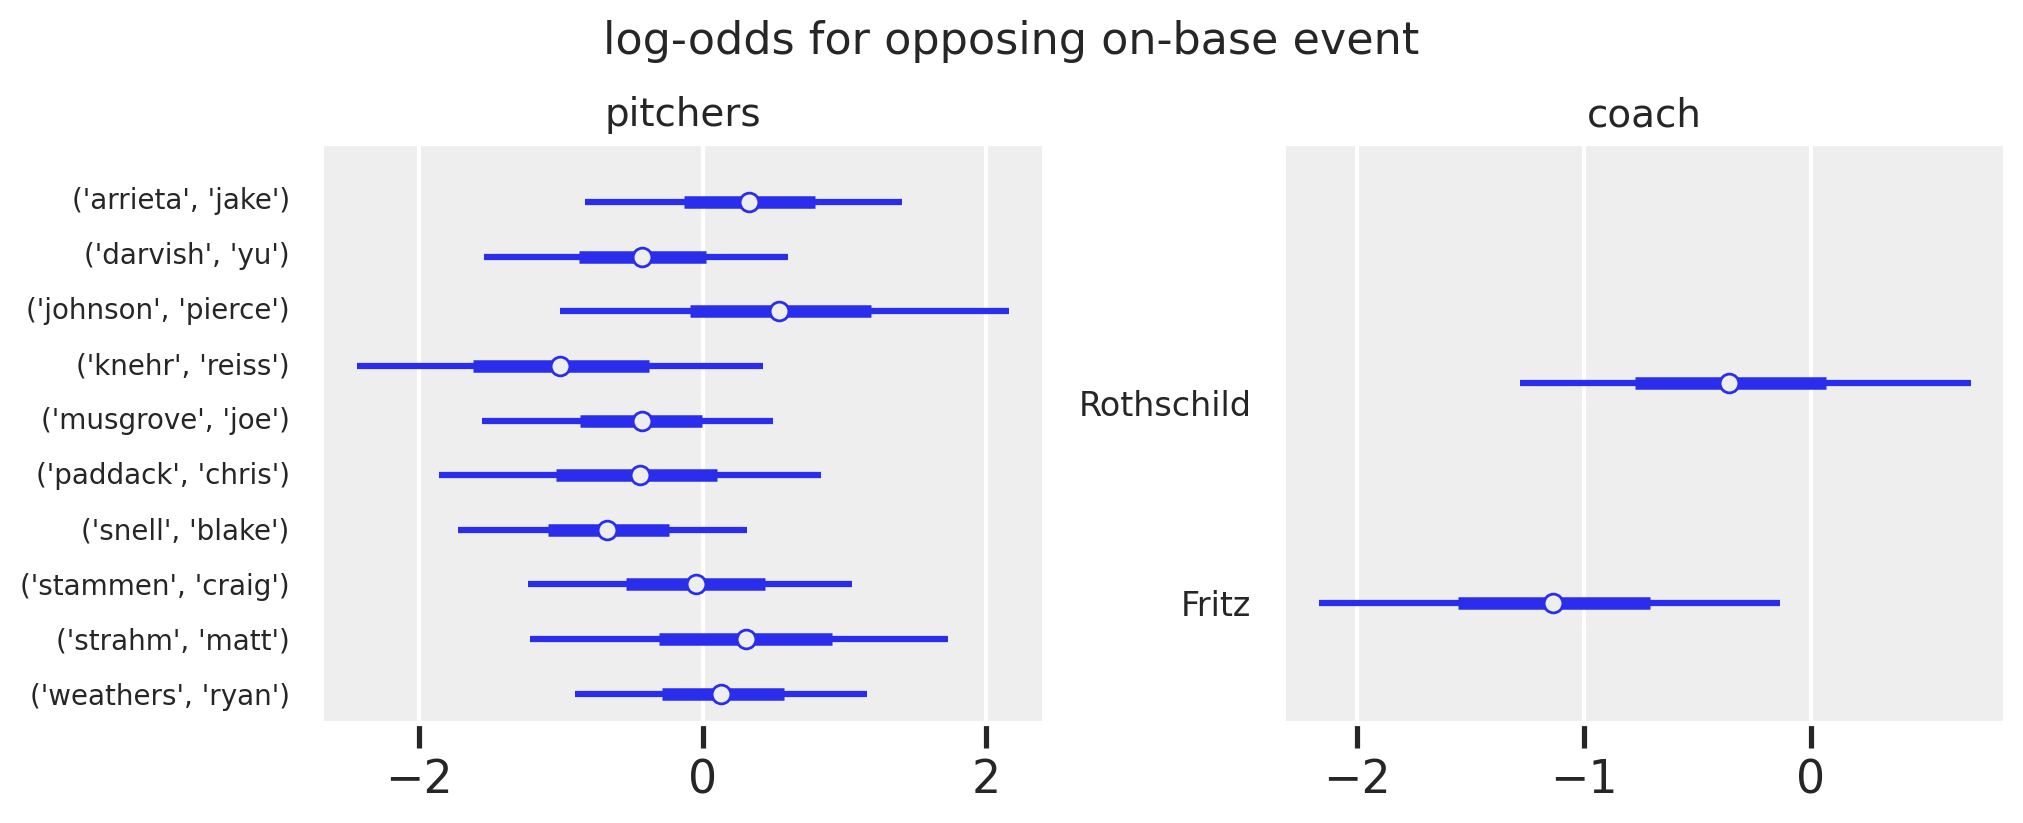

<IPython.core.display.Javascript object>

In [130]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m1, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

Here you can get a general sense of pitcher performance but one thing I'd like to highlight are the differences in the credible intervals for each pitcher. Those with the fewest number of opposing at-bats (Johnson, Knehr, and Strahm) also have the widest intervals, reflecting greater uncertainty. Those with the most (Musgrove, Darvish, and Snell) have the thinnest interval. 

As for the coach, we see some difference in the estimate of the on-base event. The width of the credible interval is not noticeably different, despite the total number of at-bats with them at the coaching helm (Rothschild coached for 363 opposing at-bats and Fritz had 139).

The difference in sample size for pitcher can be addressed with a mixed effect model, which we'll do next.

## Mixed effects

The cool thing about mixed effect models is their use of adaptive priors. This allows *sharing* of information between pitchers. We can get better estimates, especially for starting pitchers that have not faced many opposing batters by learning from the performance of other pitchers. Some information sharing will also happen with the coach variable. Here is what a mixed effect model looks like.

### Centered paramaterization

**Model `m2` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{pitcher and coach, encoded as index variables}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) \tag{adaptive prior for pitcher}$$

$$\gamma_j \sim \text{Normal}(0, \sigma_{\gamma}) \tag{adaptive prior for coach}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

$$\sigma_{\gamma} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

Note how there's no separate \(\bar{\gamma}\) prior. The \(\bar{\alpha}\) term is sufficient since we can't identify a separate mean for both the pitcher and coach intercept type.

In [249]:
with pm.Model() as m4:

    # prior for SD of pitchers, coaches
    sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    sigma_g = pm.HalfNormal("sigma_g", sigma=1)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=n_pitcher)
    g = pm.Normal("g", 0, sigma_g, shape=n_coach)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]] + g[df_padres["coach_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # increased tune and target accept from other testing
    trace_m4 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        return_inferencedata=True,
        target_accept=0.95,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a, a_bar, sigma_g, sigma_a]
INFO:pymc3:NUTS: [g, a, a_bar, sigma_g, sigma_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for

<IPython.core.display.Javascript object>

Pymc gives us some warnings about divergent transitions. This may not impact our findings significantly, but means that there is some inefficiency in exploring the posterior distribution and possibly some regions that are hard to explore and obtain samples. This tends to happen when the distribution of one variable is depednent on another, which is common in multilevel models (in this case \(\alpha_{j}\) is dependent on \(\bar{\alpha}\)).

I already applied two easy tricks for reducing the impact of divergent transitions by increasing the `tune` and `targe_accept` parameters. The next thing we can try is **re-paramaterization** of the model into a "non-centered" form. The model as shown above is called a "centered" form.

### Non-centered paramaterization

The non-centered paramaterization uses transformation to sample a variable with a posterior distribution that is easier to explore. We then transform back to get the desired parameters and so in the end it is mathematically equivalent.

While we won't use the centered paramterization within the pymc block of code, I'm showing it here in the model equation so that you can better see the transformation.

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{centered parameterization for comparison}$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{PITCHER}[i]}\sigma_{\alpha} + x_{\text{COACH}[i]}\sigma_{\gamma} \tag{non-centered parameterization}$$

$$z_j \sim \text{Normal}(0, 1) \tag{standardized intercepts for pitcher}$$

$$x_j \sim \text{Normal}(0, 1) \tag{standardized intercept for coach}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

$$\sigma_{\gamma} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

In [138]:
# Looked at repo code for R 13.29
with pm.Model() as m3:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    sigma_g = pm.HalfNormal("sigma_g", sigma=1)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(
        a_bar
        + z[df_padres["pitcher_code"]] * sigma_a
        + x[df_padres["coach_code"]] * sigma_g
    )

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, z, sigma_g, sigma_a, a_bar]
INFO:pymc3:NUTS: [x, z, sigma_g, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

As you can see, we have no more divergence warnings! We can work with the model with the results from the non-centered parameterization to compare the results from the fixed and mixed effects models.

## Comparison of fixed-effects and mixed-effects models

The first thing we can do is plot the posterior distributions of the parameters for each pitcher and coach, with the fixed and mixed effects models. To visualize this clearly, we'll have to do some of our own coding instead of relying on arviz's `plot_forest` function.

In [155]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m3 = az.summary(trace_m3)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m3[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary["vars"] = df_summary.index
df_summary.reset_index(drop=True, inplace=True)
df_summary.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.605,0.616,-1.588,0.364,a[0]
1,-0.419,0.671,-1.541,0.600,-0.967,0.588,-1.956,-0.080,a[1]
2,0.543,0.988,-1.006,2.163,-0.755,0.665,-1.747,0.374,a[2]
3,-1.024,0.919,-2.441,0.424,-1.014,0.646,-2.007,0.010,a[3]
4,-0.434,0.642,-1.559,0.497,-0.997,0.572,-1.963,-0.176,a[4]


<IPython.core.display.Javascript object>

[(0.0, 1.0),
 (-1.0, 10.0),
 Text(0.5, 0, 'proportion predicted\nfor on-base event'),
 Text(0, 0.5, 'pitcher index')]

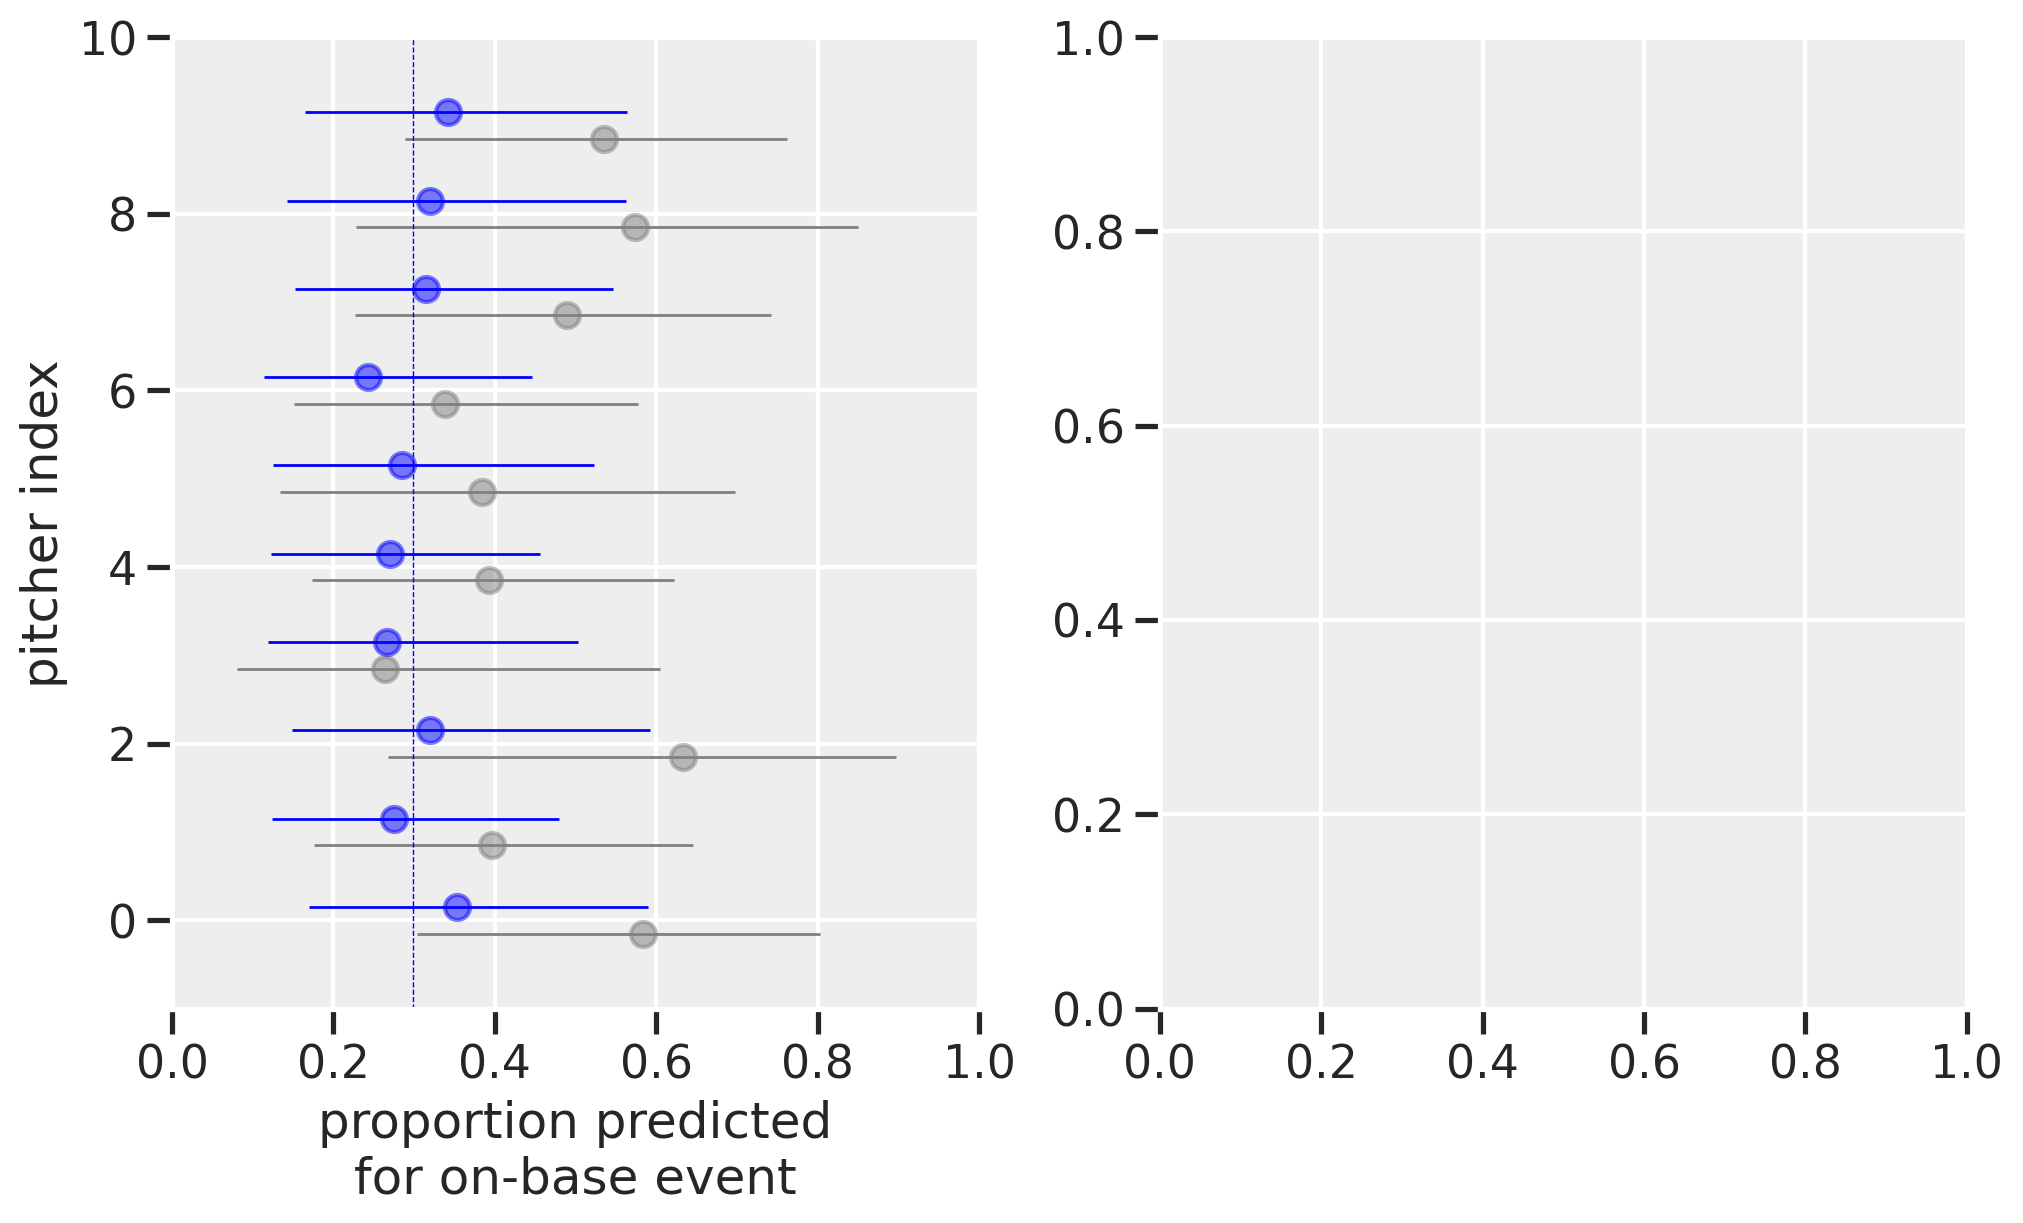

<IPython.core.display.Javascript object>

In [168]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Use ax1 for pitchers, ax2 for coaches
df_summary_pitcher = df_summary[df_summary["vars"].str.contains("a")]
df_summary_coach = df_summary[df_summary["vars"].str.contains("g")]

# Plot means
ax1.scatter(
    logistic(df_summary_pitcher["mean_x"]),
    df_summary_pitcher.index - 0.15,
    color="gray",
    alpha=0.5,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary_pitcher["mean_y"]),
    df_summary_pitcher.index + 0.15,
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary_pitcher.index - 0.15,
    xmin=logistic(df_summary_pitcher["hdi_5.5%_x"]),
    xmax=logistic(df_summary_pitcher["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary_pitcher.index + 0.15,
    xmin=logistic(df_summary_pitcher["hdi_5.5%_y"]),
    xmax=logistic(df_summary_pitcher["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m3).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
# fe_mean = df_bangladesh["use.contraception"].mean()
# ax1.plot(
#     [-10, 62],
#     [fe_mean, fe_mean],
#     color="red",
#     lw=0.5,
#     linestyle="--",
#     alpha=1,
#     label="fixed effect mean",
# )


# ax1.legend()
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 10],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

In [171]:
me_mean

0.29859443999451146

<IPython.core.display.Javascript object>

## Comparison with centered paramaterization

In [181]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m2 = az.summary(trace_m2)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary2 = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m2[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary2["vars"] = df_summary2.index
df_summary2.reset_index(drop=True, inplace=True)
df_summary2.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.637,0.478,-1.409,0.091,a[0]
1,-0.419,0.671,-1.541,0.600,-0.973,0.452,-1.722,-0.332,a[1]
2,0.543,0.988,-1.006,2.163,-0.802,0.519,-1.663,-0.046,a[2]
3,-1.024,0.919,-2.441,0.424,-1.000,0.508,-1.794,-0.224,a[3]
4,-0.434,0.642,-1.559,0.497,-1.010,0.437,-1.681,-0.323,a[4]


<IPython.core.display.Javascript object>

[Text(0, 0, "('arrieta', 'jake')"),
 Text(0, 1, "('darvish', 'yu')"),
 Text(0, 2, "('johnson', 'pierce')"),
 Text(0, 3, "('knehr', 'reiss')"),
 Text(0, 4, "('musgrove', 'joe')"),
 Text(0, 5, "('paddack', 'chris')"),
 Text(0, 6, "('snell', 'blake')"),
 Text(0, 7, "('stammen', 'craig')"),
 Text(0, 8, "('strahm', 'matt')"),
 Text(0, 9, "('weathers', 'ryan')")]

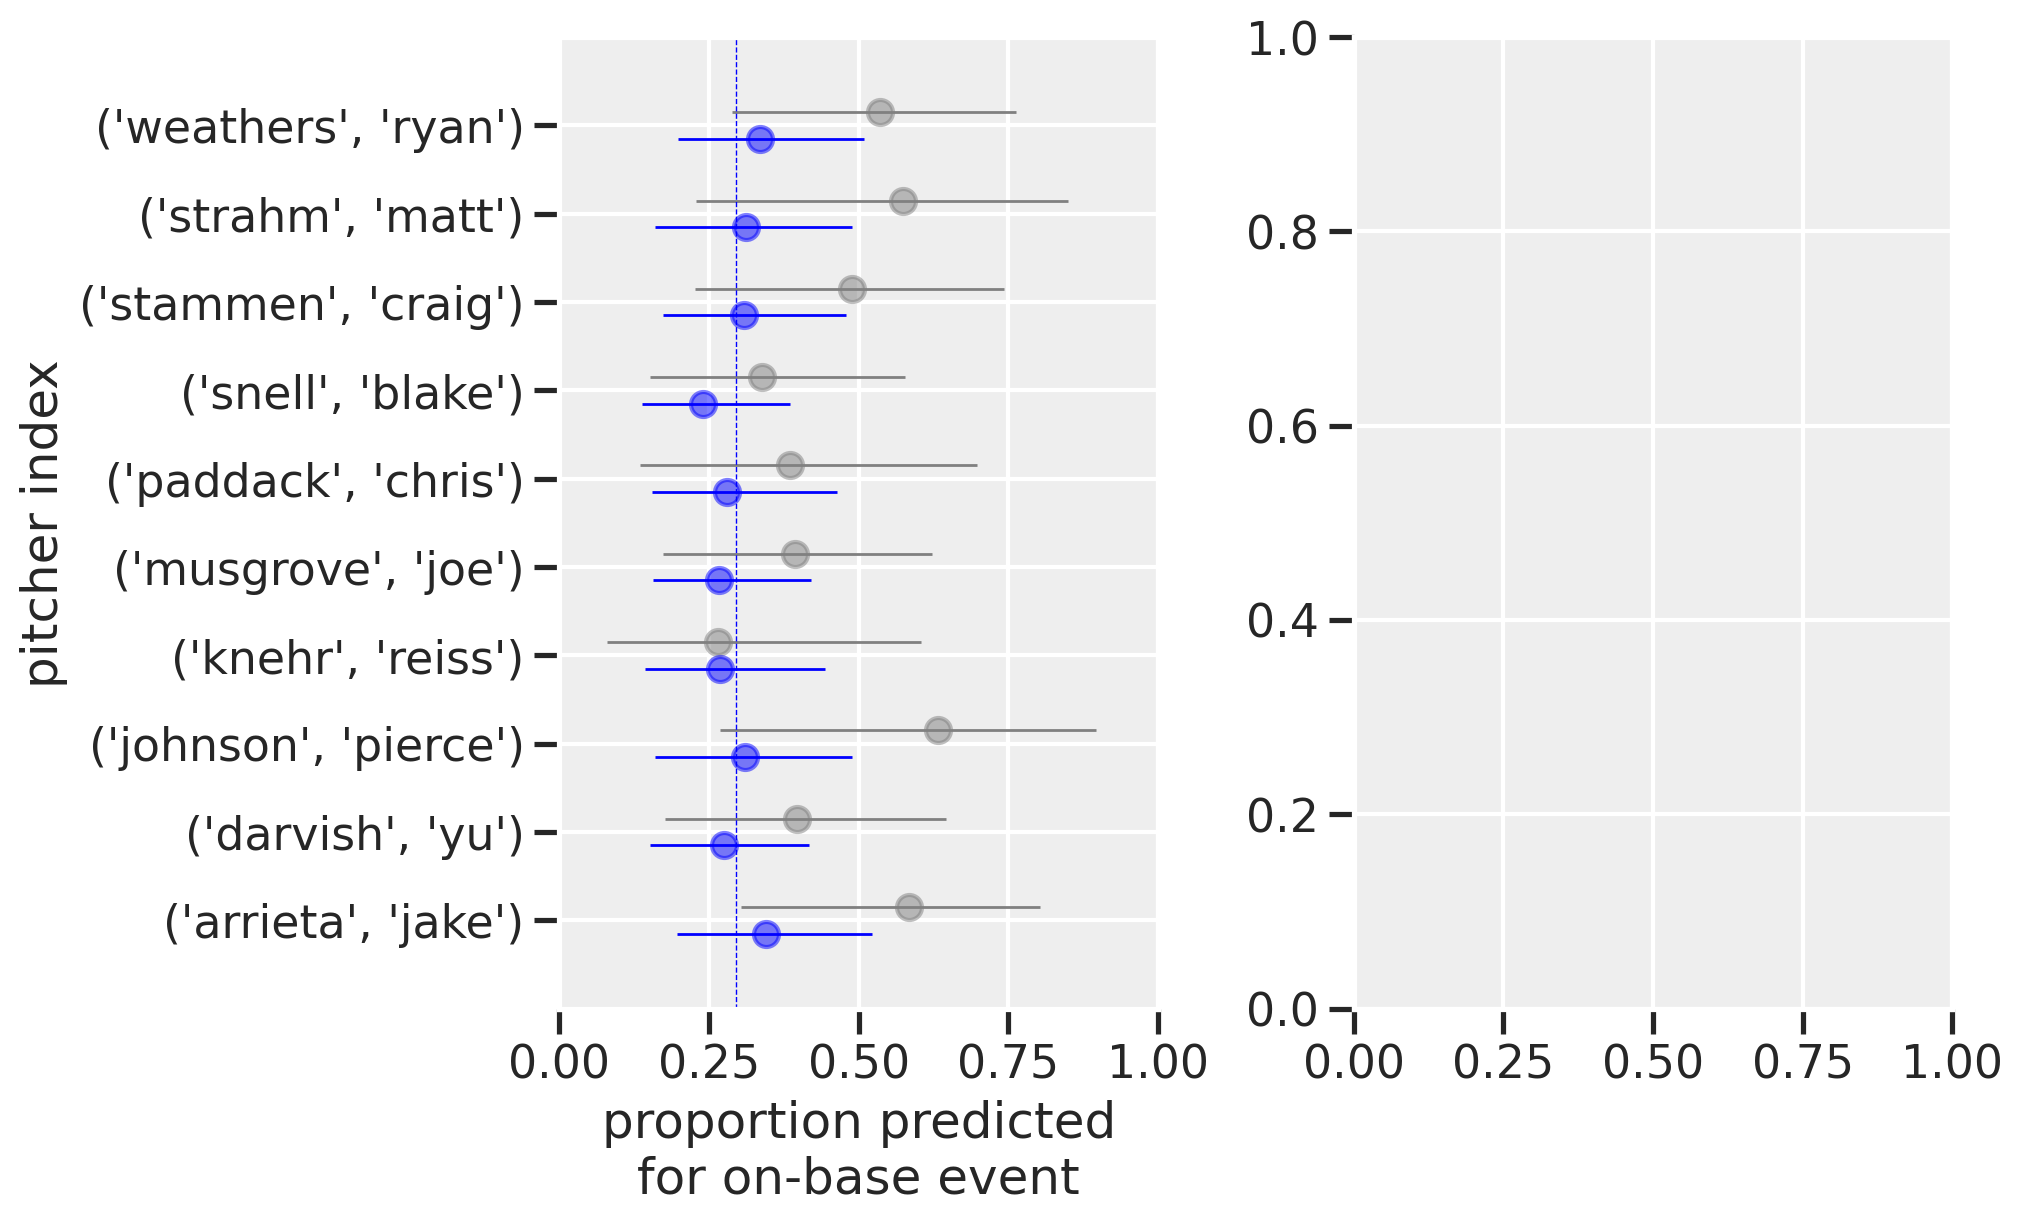

<IPython.core.display.Javascript object>

In [188]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Use ax1 for pitchers, ax2 for coaches
df_summary2_pitcher = df_summary2[df_summary2["vars"].str.contains("a")]
df_summary2_coach = df_summary2[df_summary2["vars"].str.contains("g")]

# Plot means
ax1.scatter(
    logistic(df_summary2_pitcher["mean_x"]),
    df_summary2_pitcher.index + 0.15,
    color="gray",
    alpha=0.5,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary2_pitcher["mean_y"]),
    df_summary2_pitcher.index - 0.15,
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary2_pitcher.index + 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_x"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary2_pitcher.index - 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_y"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m2).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
# fe_mean = df_bangladesh["use.contraception"].mean()
# ax1.plot(
#     [-10, 62],
#     [fe_mean, fe_mean],
#     color="red",
#     lw=0.5,
#     linestyle="--",
#     alpha=1,
#     label="fixed effect mean",
# )


# ax1.legend()
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 10],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

ax1.set_yticks(range(10))
ax1.set_yticklabels(df_pitcher_code["pitcher"])

In [179]:
df_pitcher_code['pitcher']

,pitcher,pitcher_code
0,"('arrieta', 'jake')",0
1,"('darvish', 'yu')",1
2,"('johnson', 'pierce')",2
3,"('knehr', 'reiss')",3
4,"('musgrove', 'joe')",4
5,"('paddack', 'chris')",5
6,"('snell', 'blake')",6
7,"('stammen', 'craig')",7
8,"('strahm', 'matt')",8
9,"('weathers', 'ryan')",9


<IPython.core.display.Javascript object>

In [170]:
df_padres["n_ob"].sum() / df_padres["n_ab"].sum()

0.30278884462151395

<IPython.core.display.Javascript object>

In [167]:
logistic(az.summary(trace_m3).loc["a_bar", "mean"])

0.29859443999451146

<IPython.core.display.Javascript object>

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

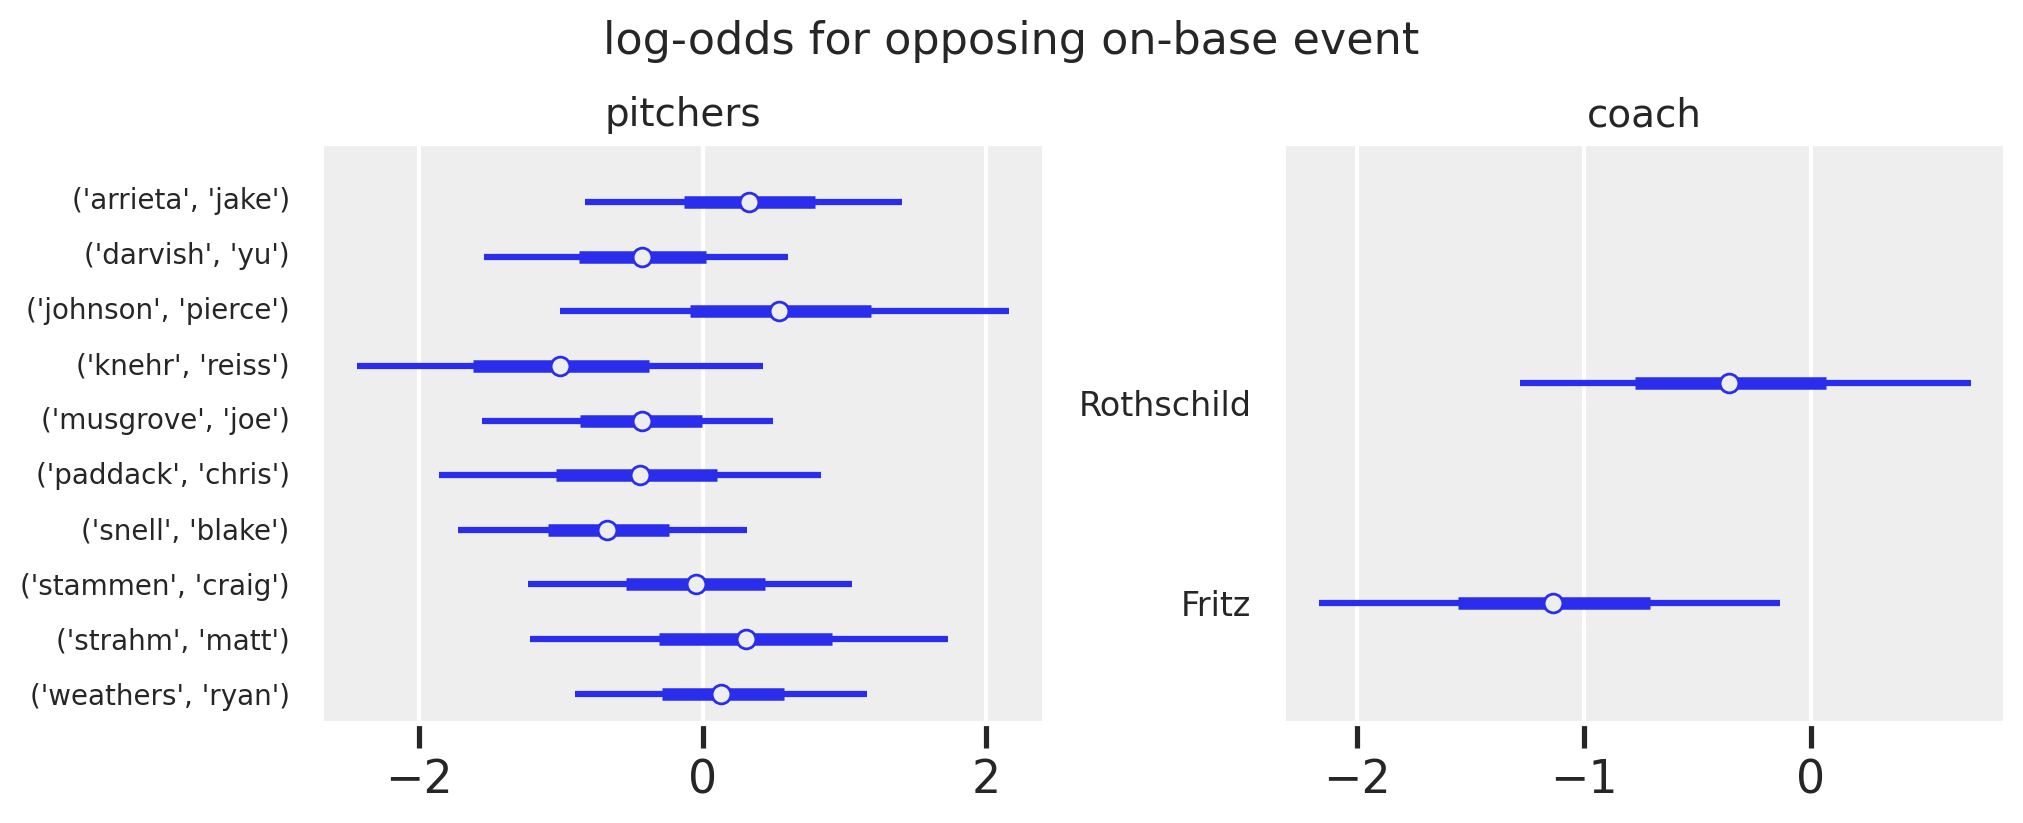

<IPython.core.display.Javascript object>

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m1, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

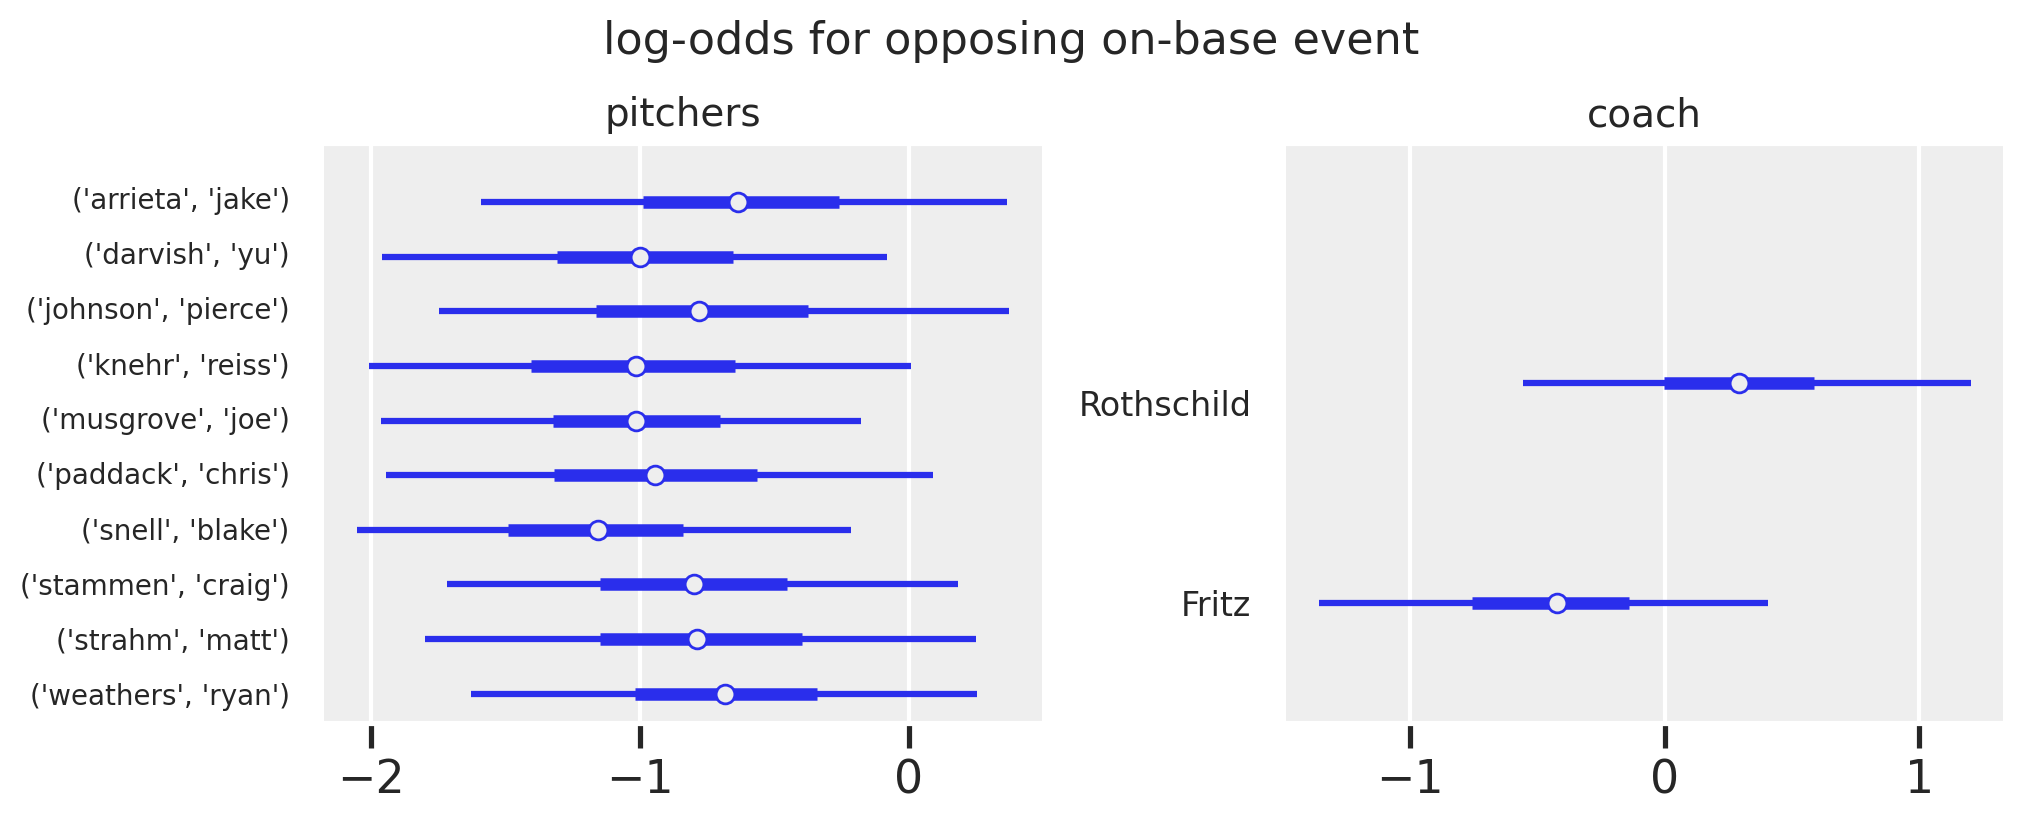

<IPython.core.display.Javascript object>

In [140]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m3, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m3, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

In [172]:
df_summary_pitcher.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.605,0.616,-1.588,0.364,a[0]
1,-0.419,0.671,-1.541,0.600,-0.967,0.588,-1.956,-0.080,a[1]
2,0.543,0.988,-1.006,2.163,-0.755,0.665,-1.747,0.374,a[2]
3,-1.024,0.919,-2.441,0.424,-1.014,0.646,-2.007,0.010,a[3]
4,-0.434,0.642,-1.559,0.497,-0.997,0.572,-1.963,-0.176,a[4]


<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary_pitcher, x="sd_x", y="sd_y", size="n_women", color="gray", ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD"
)

## Comparison with chimpanzees code

In [258]:
df_padres

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code,coach_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,3,0,0
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,6,0,0
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,4,0,0
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild,0,0,0
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,9,0,0
5,"('darvish', 'yu')",2021-08-07,25,4,0.160000,Rothschild,1,0,0
6,"('snell', 'blake')",2021-08-08,26,5,0.192308,Rothschild,6,0,0
7,"('musgrove', 'joe')",2021-08-09,24,6,0.250000,Rothschild,4,0,0
8,"('stammen', 'craig')",2021-08-10,11,6,0.545455,Rothschild,7,0,0
9,"('weathers', 'ryan')",2021-08-11,21,8,0.380952,Rothschild,9,0,0


<IPython.core.display.Javascript object>

In [252]:
# Looked at repo code for R 13.29
with pm.Model() as m3:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    #     sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    #     sigma_g = pm.HalfNormal("sigma_g", sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(
        a_bar
        + z[df_padres["pitcher_code"]] * sigma_a
        + x[df_padres["coach_code"]] * sigma_g
    )

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, z, sigma_g, sigma_a, a_bar]
INFO:pymc3:NUTS: [x, z, sigma_g, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [253]:
# Looked at repo code for R 13.29
with pm.Model() as m3a:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    #     sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    #     sigma_g = pm.HalfNormal("sigma_g", sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    # sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    # x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    # _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma_a)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3a = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma_a, a_bar]
INFO:pymc3:NUTS: [z, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

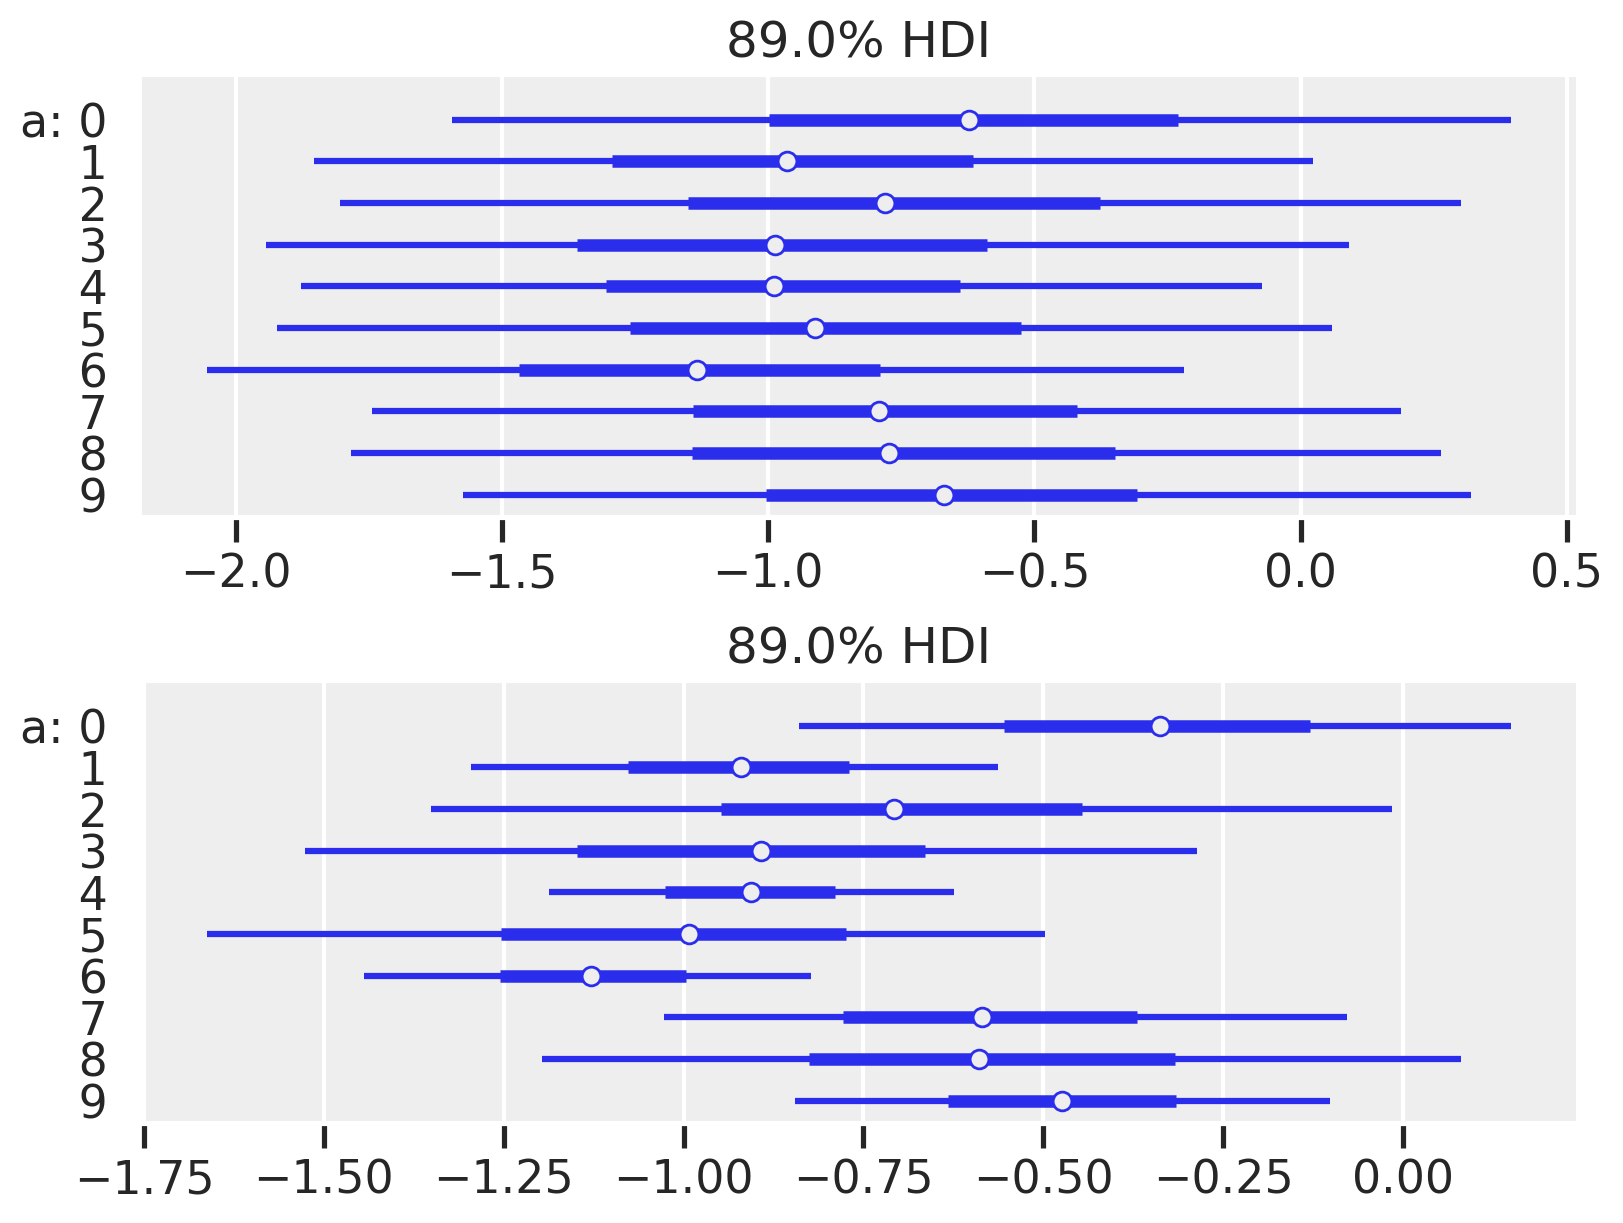

<IPython.core.display.Javascript object>

In [255]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
az.plot_forest(trace_m3, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m3a, var_names="a", combined=True, ax=ax2)

In [ ]:
with pm.Model() as m_13_4nca:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0.0, 1.0, shape=Nactor)
    x = pm.Normal("x", 0.0, 1.0, shape=Nblock)

    _ = pm.Deterministic("a", a_bar + z * sigma_a)  # actor intercepts
    _ = pm.Deterministic("g", x * sigma_g)  # block intercepts
    p = pm.math.invlogit(a_bar + z[actor] * sigma_a + x[block] * sigma_g)
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_13_4nca = pm.sample(tune=3000, target_accept=0.9, random_seed=RANDOM_SEED)
    #idata_13_4nca = az.from_pymc3(trace_13_4nc)

Appendix: Environment and system parameters

In [6]:
%watermark -n -u -v -iv -w

Last updated: Mon Oct 04 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
numpy     : 1.20.1
pymc3     : 3.11.0
pandas    : 1.2.1
matplotlib: 3.3.4
seaborn   : 0.11.1
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
arviz     : 0.11.1
daft      : 0.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

# NEXT STEPS: double check equation and model parameters for pitcher and coach models

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>